In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tabular-playground-series-aug-2022/sample_submission.csv
/kaggle/input/tabular-playground-series-aug-2022/train.csv
/kaggle/input/tabular-playground-series-aug-2022/test.csv


## Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier,GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from imblearn.combine import SMOTETomek 

from sklearn.metrics import confusion_matrix,f1_score,precision_score,roc_auc_score,recall_score,balanced_accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer


## Data Inspection

In [3]:
train = pd.read_csv('/kaggle/input/tabular-playground-series-aug-2022/train.csv')
test = pd.read_csv('/kaggle/input/tabular-playground-series-aug-2022/test.csv')

In [4]:
train.shape, test.shape

((26570, 26), (20775, 25))

In [5]:
train.isnull().sum()/train.shape[0]*100

id                0.000000
product_code      0.000000
loading           0.940911
attribute_0       0.000000
attribute_1       0.000000
attribute_2       0.000000
attribute_3       0.000000
measurement_0     0.000000
measurement_1     0.000000
measurement_2     0.000000
measurement_3     1.433948
measurement_4     2.024840
measurement_5     2.544223
measurement_6     2.995860
measurement_7     3.526534
measurement_8     3.944298
measurement_9     4.617990
measurement_10    4.892736
measurement_11    5.525028
measurement_12    6.025593
measurement_13    6.676703
measurement_14    7.053067
measurement_15    7.561159
measurement_16    7.941287
measurement_17    8.596161
failure           0.000000
dtype: float64

In [6]:
test.isnull().sum()/test.shape[0]*100

id                0.000000
product_code      0.000000
loading           1.073406
attribute_0       0.000000
attribute_1       0.000000
attribute_2       0.000000
attribute_3       0.000000
measurement_0     0.000000
measurement_1     0.000000
measurement_2     0.000000
measurement_3     1.583634
measurement_4     1.968712
measurement_5     2.445247
measurement_6     3.003610
measurement_7     3.465704
measurement_8     4.072202
measurement_9     4.351384
measurement_10    5.135981
measurement_11    5.468111
measurement_12    5.968712
measurement_13    6.271961
measurement_14    6.931408
measurement_15    7.422383
measurement_16    8.077016
measurement_17    8.375451
dtype: float64

Null values present in our data

In [7]:
train.product_code.value_counts()

C    5765
E    5343
B    5250
D    5112
A    5100
Name: product_code, dtype: int64

In [8]:
test.product_code.value_counts()

F    5422
I    5228
G    5107
H    5018
Name: product_code, dtype: int64

In [9]:
train.head()

,id,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,...,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
0,0,A,80.10,material_7,material_8,9,5,7,8,4,...,10.672,15.859,17.594,15.193,15.029,NaN,13.034,14.684,764.100,0
1,1,A,84.89,material_7,material_8,9,5,14,3,3,...,12.448,17.947,17.915,11.755,14.732,15.425,14.395,15.631,682.057,0
2,2,A,82.43,material_7,material_8,9,5,12,1,5,...,12.715,15.607,NaN,13.798,16.711,18.631,14.094,17.946,663.376,0
3,3,A,101.07,material_7,material_8,9,5,13,2,6,...,12.471,16.346,18.377,10.020,15.250,15.562,16.154,17.172,826.282,0
4,4,A,188.06,material_7,material_8,9,5,9,2,8,...,10.337,17.082,19.932,12.428,16.182,12.760,13.153,16.412,579.885,0


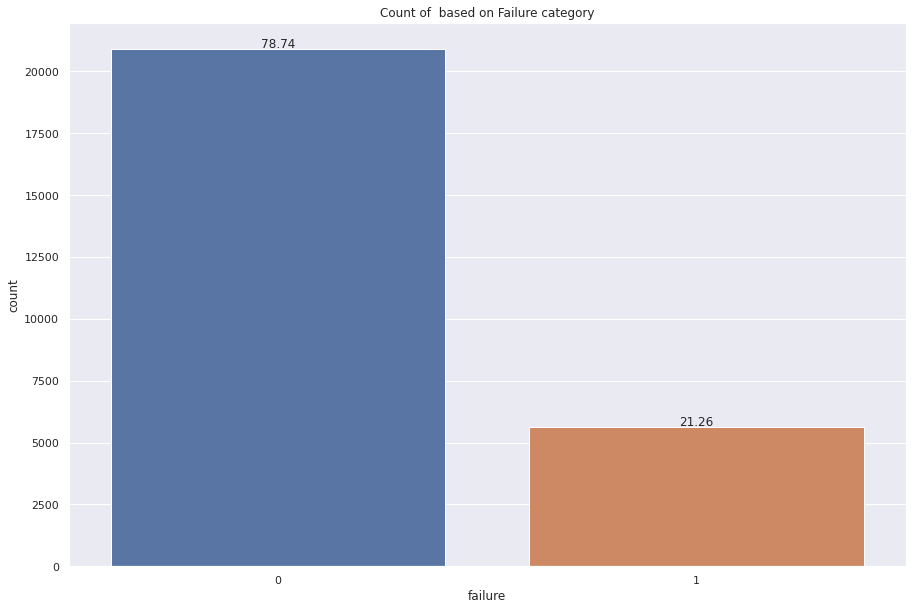

In [10]:
plt.figure(figsize=[15,10])
plot = sns.countplot(train['failure'])
#plt.xticks(rotation=90)
for p in plot.patches:
    plot.annotate(round(p.get_height()/train.shape[0]*100,2), 
                        (p.get_x() + p.get_width() / 2.0, 
                         p.get_height()), 
                        ha = 'center', 
                        va = 'center', 
                        xytext = (0, 5),
                        textcoords = 'offset points')
plt.title("Count of  based on Failure category");

* __`id` column is same as index, we can drop it__
* __We need to handle null values__
* __Dataset is imbalanced__

## Data Preprocessing
### Handling Null values

In [11]:
# null value columns
null_col_train = train.columns[train.isnull().any()].tolist()
len(null_col_train)

16

In [12]:
train[null_col_train].head()

,loading,measurement_3,measurement_4,measurement_5,measurement_6,measurement_7,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17
0,80.10,18.040,12.518,15.748,19.292,11.739,20.155,10.672,15.859,17.594,15.193,15.029,NaN,13.034,14.684,764.100
1,84.89,18.213,11.540,17.717,17.893,12.748,17.889,12.448,17.947,17.915,11.755,14.732,15.425,14.395,15.631,682.057
2,82.43,18.057,11.652,16.738,18.240,12.718,18.288,12.715,15.607,NaN,13.798,16.711,18.631,14.094,17.946,663.376
3,101.07,17.295,11.188,18.576,18.339,12.583,19.060,12.471,16.346,18.377,10.020,15.250,15.562,16.154,17.172,826.282
4,188.06,19.346,12.950,16.990,15.746,11.306,18.093,10.337,17.082,19.932,12.428,16.182,12.760,13.153,16.412,579.885


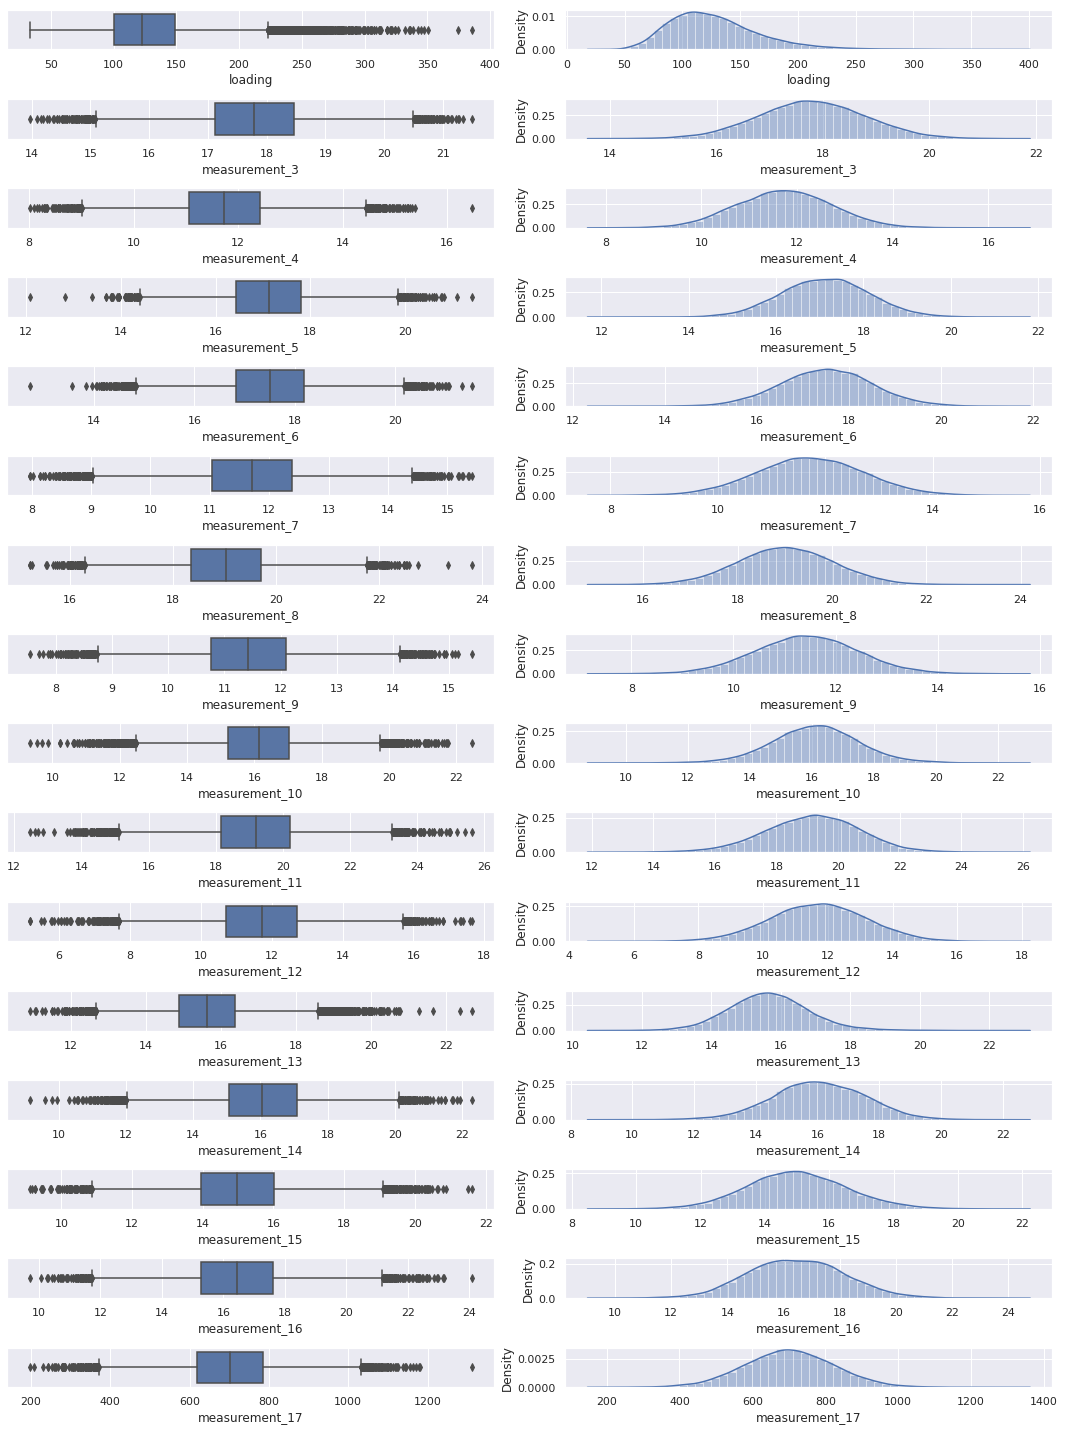

In [13]:
plt.figure(figsize=[15,20])
i = 1
l = len(null_col_train)
for col in null_col_train:
    plt.subplot(l,2,i)
    sns.boxplot(train[col])
    i+=1
    plt.subplot(l,2,i)
    sns.distplot(train[col])
    i+=1
plt.tight_layout()
plt.show()

* All feature containing null values are numeric
* Mostly all features contains outliers hence we will use median to fill up the null values

In [14]:
train_data = train.copy()
train_data[null_col_train] = train_data[null_col_train].fillna(train_data[null_col_train].mean())

In [15]:
train_data.isnull().sum()/train_data.shape[0]*100

id                0.0
product_code      0.0
loading           0.0
attribute_0       0.0
attribute_1       0.0
attribute_2       0.0
attribute_3       0.0
measurement_0     0.0
measurement_1     0.0
measurement_2     0.0
measurement_3     0.0
measurement_4     0.0
measurement_5     0.0
measurement_6     0.0
measurement_7     0.0
measurement_8     0.0
measurement_9     0.0
measurement_10    0.0
measurement_11    0.0
measurement_12    0.0
measurement_13    0.0
measurement_14    0.0
measurement_15    0.0
measurement_16    0.0
measurement_17    0.0
failure           0.0
dtype: float64

In [16]:
# dropping id column
train_data.drop('id',axis=1,inplace=True)

### lets look into categorical features

In [17]:
categorical_col = train_data.select_dtypes(include='O').columns.tolist()
categorical_col

['product_code', 'attribute_0', 'attribute_1']

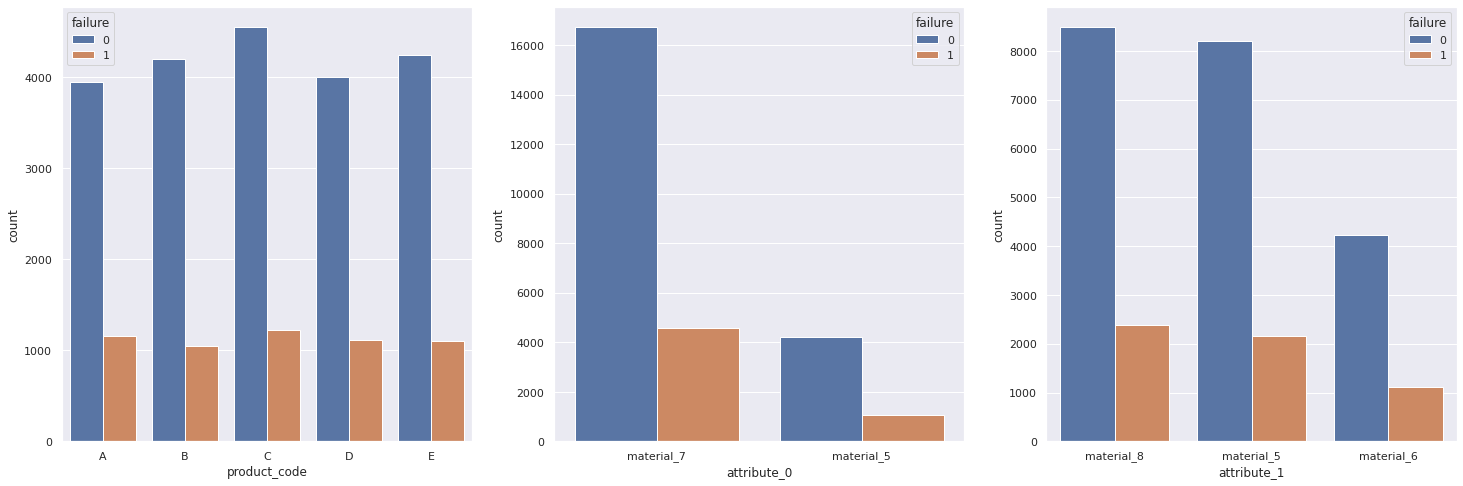

In [18]:
plt.figure(figsize=[25,8])
for i,col in enumerate(categorical_col):
    plt.subplot(1,3,i+1)
    sns.countplot(train_data[col], hue=train_data['failure'])

In [19]:
for col in categorical_col:
    print(f'Train dataset: \n\n{train[col].value_counts()}')
    print(f'\nTest dataset: \n\n{test[col].value_counts()}')
    print('='*30)

Train dataset: 

C    5765
E    5343
B    5250
D    5112
A    5100
Name: product_code, dtype: int64

Test dataset: 

F    5422
I    5228
G    5107
H    5018
Name: product_code, dtype: int64
Train dataset: 

material_7    21320
material_5     5250
Name: attribute_0, dtype: int64

Test dataset: 

material_5    10529
material_7    10246
Name: attribute_0, dtype: int64
Train dataset: 

material_8    10865
material_5    10362
material_6     5343
Name: attribute_1, dtype: int64

Test dataset: 

material_6    10529
material_5     5228
material_7     5018
Name: attribute_1, dtype: int64


__`product_code` and `attribute_1` has different categories in train and test datasets, hence we will drop both__

In [20]:
# convert categorical to numerical
train_ = pd.get_dummies(train_data, columns=['attribute_0'])
train_.drop(['product_code','attribute_1'],axis=1, inplace=True)

### lets look numerical features

In [21]:
numerical_col = train_data.select_dtypes(exclude='O').columns.tolist()
numerical_col.remove('failure')
# len(numerical_col)

In [22]:
corr_data = train_.corr()

<AxesSubplot:>

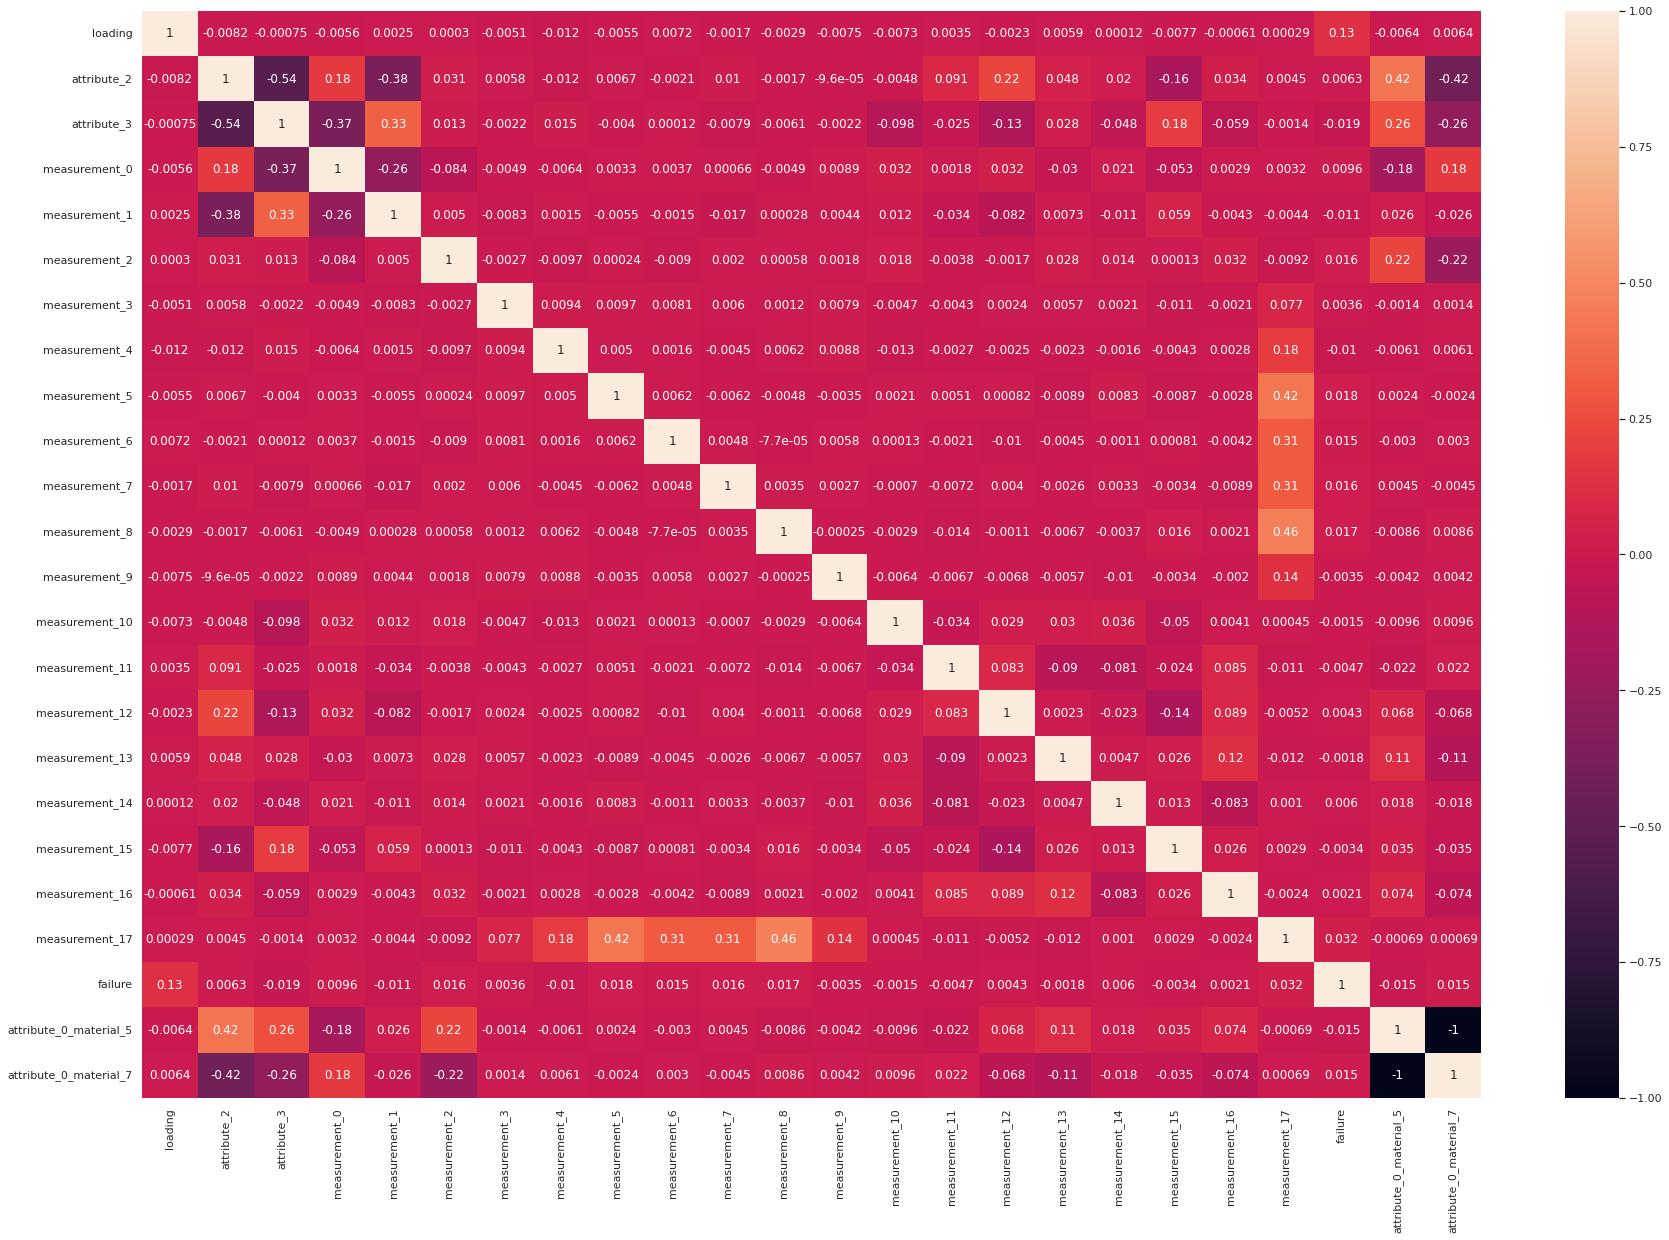

In [23]:
plt.figure(figsize=[30,20])
sns.heatmap(corr_data, annot=True)

__So many numbers, lets focus on important__

In [24]:
#thanks to : https://www.kaggle.com/code/koustavghosh149/simple-approach-to-house-price-prediction-dataset

def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [25]:
drop_col = list(correlation(train_,0.7))
drop_col

['attribute_0_material_7']

In [26]:
train_.drop(columns=drop_col, inplace=True)

# Model creatation
## without resampling

In [27]:
X = train_.drop('failure',axis=1)
y = train_[['failure']]

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=100)

In [29]:
X_train.shape,X_test.shape

((21256, 22), (5314, 22))

#### Normalization

In [30]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train),columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test),columns=X_test.columns)

## ML Models

In [31]:
# original fro: https://github.com/prateeknigam9/Hinglish_Classifier/blob/main/CaseStudy_Hinglish.ipynb

def metrics_plot(model,train_in,train_out,to_pred,true):
    """
    To plot the metrics and result of performance of model
    =======================================================
    INPUT-
        model: Model Selected
        train_in: training input data
        train_out: training target data
        true: Ground Truth
        to_pred: Values to predict
    """
    accuracy_train = model.score(train_in,train_out)
    accuracy = model.score(to_pred, true)
    
    f1 = f1_score(true, model.predict(to_pred), average='micro', labels=np.unique(model.predict(to_pred)))
    precision = precision_score(true,model.predict(to_pred),average='micro')
    rec = recall_score(true,model.predict(to_pred),average='micro')
    bal_acc = balanced_accuracy_score(true, model.predict(to_pred))
    fnr = 1- rec
   # auc = roc_auc_score(true,model.predict_proba(to_pred))
    
    metrics={}
    metrics['train_accuracy'] = accuracy_train
    metrics['accuracy'] = accuracy
    metrics['balanced_accuracy'] = bal_acc
    metrics['F1_score'] = f1
    metrics['precision'] = precision
    metrics['recall'] = rec
    metrics['FNR'] = fnr
   # metrics['auc'] = auc
    
    print("="*20,"Model metrics", "="*20)
    print(pd.DataFrame([metrics]))
    
    print("\n")
#    print("="*20,"Example output", "="*20)
#     pred_top_10 = model.predict(X_test[:10])

#     print(pd.DataFrame(pred_top_10),true[:10].values.tolist(),columns=['Predicted']))
# #    print(temp.head(7))
    print("\n")
    print("="*20,"Confusion Matrix","="*20)
    plt.figure(figsize=(8,5))
    sns.heatmap(confusion_matrix(true,model.predict(to_pred)),annot=True,cmap='Blues')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    return metrics

==================== Model metrics ====================
   train_accuracy  accuracy  balanced_accuracy  F1_score  precision    recall  \
0        0.788201  0.783214           0.500194  0.783214   0.783214  0.783214   

        FNR  
0  0.216786  




==================== Confusion Matrix ====================


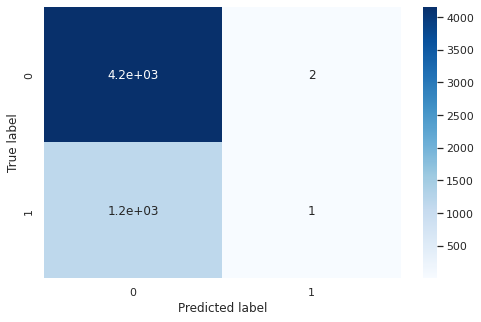

In [32]:
lr_model = LogisticRegression(C=0.01)
lr_model.fit(X_train_scaled,y_train)
lr_metrics = metrics_plot(lr_model,X_train_scaled,y_train,X_test_scaled,y_test)

==================== Model metrics ====================
   train_accuracy  accuracy  balanced_accuracy  F1_score  precision    recall  \
0        0.807631  0.774746           0.506419  0.774746   0.774746  0.774746   

        FNR  
0  0.225254  




==================== Confusion Matrix ====================


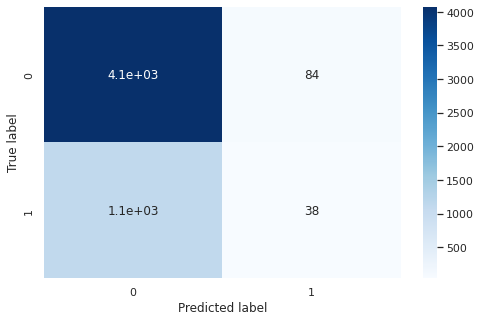

In [33]:
dt_model = DecisionTreeClassifier(max_depth=10)
dt_model.fit(X_train_scaled,y_train)
dt_metrics = metrics_plot(dt_model,X_train_scaled,y_train,X_test_scaled,y_test)

==================== Model metrics ====================
   train_accuracy  accuracy  balanced_accuracy  F1_score  precision    recall  \
0        0.788436  0.783402                0.5  0.878548   0.783402  0.783402   

        FNR  
0  0.216598  




==================== Confusion Matrix ====================


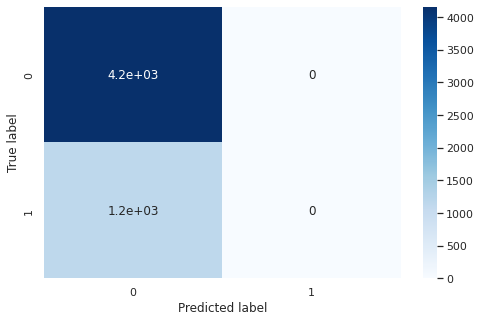

In [34]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=8)
rf_model.fit(X_train_scaled,y_train)
rf_metrics = metrics_plot(rf_model,X_train_scaled,y_train,X_test_scaled,y_test)

==================== Model metrics ====================
   train_accuracy  accuracy  balanced_accuracy  F1_score  precision    recall  \
0        0.788107  0.783591           0.501063  0.783591   0.783591  0.783591   

        FNR  
0  0.216409  




==================== Confusion Matrix ====================


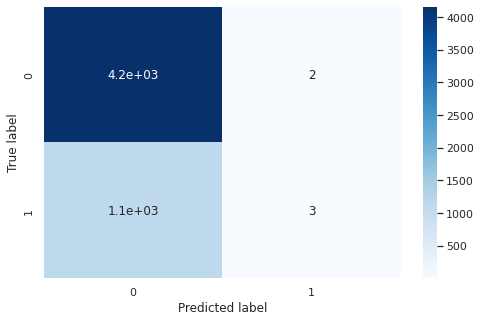

In [35]:
v_model = VotingClassifier(estimators=[('lr',LogisticRegression()),('rf',RandomForestClassifier(max_depth=8,n_estimators=50)),('nb',GaussianNB())])
v_model.fit(X_train_scaled,y_train)
v_metrics = metrics_plot(v_model,X_train_scaled,y_train,X_test_scaled,y_test)

==================== Model metrics ====================
   train_accuracy  accuracy  balanced_accuracy  F1_score  precision    recall  \
0        0.788907  0.783402                0.5  0.878548   0.783402  0.783402   

        FNR  
0  0.216598  




==================== Confusion Matrix ====================


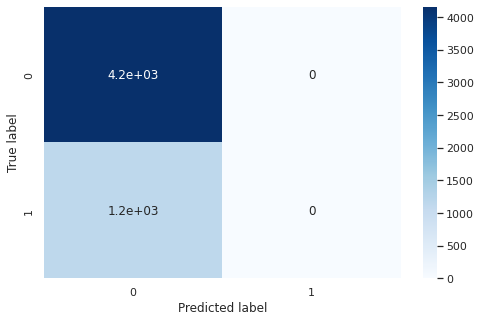

In [36]:
gbdt_model = GradientBoostingClassifier(learning_rate=0.05)
gbdt_model.fit(X_train_scaled,y_train)
gbdt_metrics = metrics_plot(gbdt_model,X_train_scaled,y_train,X_test_scaled,y_test)

==================== Model metrics ====================
   train_accuracy  accuracy  balanced_accuracy  F1_score  precision    recall  \
0        0.940864  0.766654           0.506283  0.766654   0.766654  0.766654   

        FNR  
0  0.233346  




==================== Confusion Matrix ====================


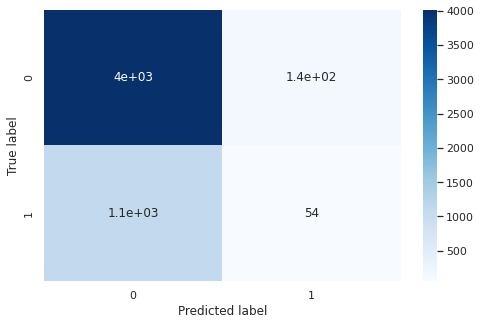

In [37]:
xgb_model = XGBClassifier(n_estimators=200,max_depth=6)
xgb_model.fit(X_train_scaled,y_train)
xgb_metrics = metrics_plot(xgb_model,X_train_scaled,y_train,X_test_scaled,y_test)

In [38]:
ML_COMPARISON = pd.DataFrame([lr_metrics,dt_metrics,rf_metrics,v_metrics,gbdt_metrics,xgb_metrics],
                             index=['LogisticRegression','DecisionTree','RandomForest','VotingClassifier','GradientBoosting','XGBoost'])
ML_COMPARISON

,train_accuracy,accuracy,balanced_accuracy,F1_score,precision,recall,FNR
LogisticRegression,0.788201,0.783214,0.500194,0.783214,0.783214,0.783214,0.216786
DecisionTree,0.807631,0.774746,0.506419,0.774746,0.774746,0.774746,0.225254
RandomForest,0.788436,0.783402,0.500000,0.878548,0.783402,0.783402,0.216598
VotingClassifier,0.788107,0.783591,0.501063,0.783591,0.783591,0.783591,0.216409
GradientBoosting,0.788907,0.783402,0.500000,0.878548,0.783402,0.783402,0.216598
XGBoost,0.940864,0.766654,0.506283,0.766654,0.766654,0.766654,0.233346


## with resampling

In [39]:
smote = SMOTETomek(random_state=100)
X_resampled, y_resampled = smote.fit_resample(X,y)
y_resampled.value_counts()

failure
0          20815
1          20815
dtype: int64

In [40]:
X_train_resampled,X_test_resampled,y_train,y_test = train_test_split(X_resampled,y_resampled,test_size=0.2,random_state=100)

In [41]:
scaler = StandardScaler()
X_train_rescale = pd.DataFrame(scaler.fit_transform(X_train_resampled),columns=X_train.columns)
X_test_rescale = pd.DataFrame(scaler.transform(X_test_resampled),columns=X_test.columns)

==================== Model metrics ====================
   train_accuracy  accuracy  balanced_accuracy  F1_score  precision    recall  \
0        0.603831  0.611338           0.611526  0.611338   0.611338  0.611338   

        FNR  
0  0.388662  




==================== Confusion Matrix ====================


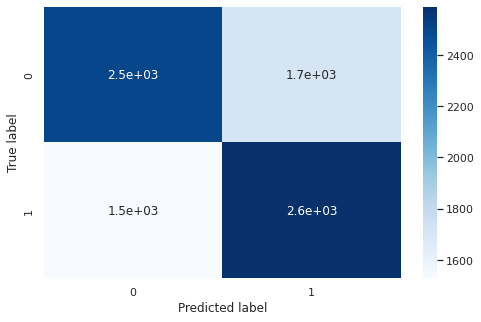

In [42]:
lr_model_re = LogisticRegression(C=0.005)
lr_model_re.fit(X_train_rescale,y_train)
lr_re_metrics = metrics_plot(lr_model_re,X_train_rescale,y_train,X_test_rescale,y_test)

==================== Model metrics ====================
   train_accuracy  accuracy  balanced_accuracy  F1_score  precision    recall  \
0        0.851069  0.682441           0.683473  0.682441   0.682441  0.682441   

        FNR  
0  0.317559  




==================== Confusion Matrix ====================


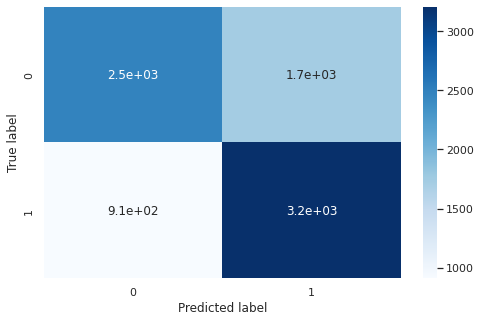

In [43]:
dt_model_re = DecisionTreeClassifier(max_depth=16)
dt_model_re.fit(X_train_rescale,y_train)
dt_re_metrics = metrics_plot(dt_model_re,X_train_rescale,y_train,X_test_rescale,y_test)

==================== Model metrics ====================
   train_accuracy  accuracy  balanced_accuracy  F1_score  precision    recall  \
0        0.771919  0.720274           0.720123  0.720274   0.720274  0.720274   

        FNR  
0  0.279726  




==================== Confusion Matrix ====================


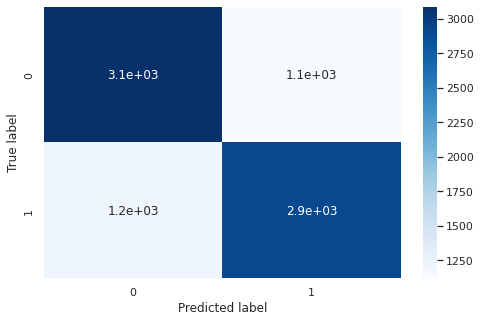

In [44]:
rf_model_re = RandomForestClassifier(n_estimators=150, max_depth=10)
rf_model_re.fit(X_train_rescale,y_train)
rf_re_metrics = metrics_plot(rf_model_re,X_train_rescale,y_train,X_test_rescale,y_test)

==================== Model metrics ====================
   train_accuracy  accuracy  balanced_accuracy  F1_score  precision    recall  \
0        0.686194  0.679918           0.680425  0.679918   0.679918  0.679918   

        FNR  
0  0.320082  




==================== Confusion Matrix ====================


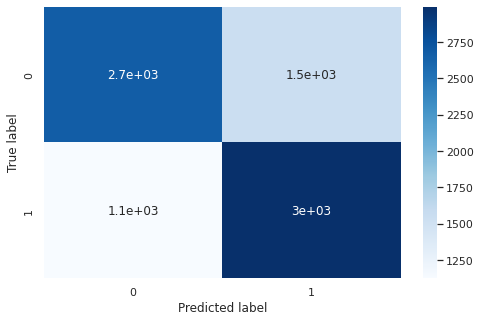

In [45]:
v_model_re = VotingClassifier(estimators=[('lr',LogisticRegression()),('rf',RandomForestClassifier(max_depth=8,n_estimators=50)),('nb',GaussianNB())])
v_model_re.fit(X_train_rescale,y_train)
v_re_metrics = metrics_plot(v_model_re,X_train_rescale,y_train,X_test_rescale,y_test)

==================== Model metrics ====================
   train_accuracy  accuracy  balanced_accuracy  F1_score  precision   recall  \
0        0.699225   0.69373           0.693466   0.69373    0.69373  0.69373   

       FNR  
0  0.30627  




==================== Confusion Matrix ====================


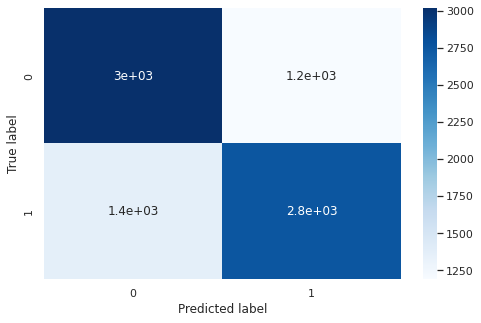

In [46]:
gbdt_model_re = GradientBoostingClassifier(learning_rate=0.05)
gbdt_model_re.fit(X_train_rescale,y_train)
gbdt_re_metrics = metrics_plot(gbdt_model_re,X_train_rescale,y_train,X_test_rescale,y_test)

==================== Model metrics ====================
   train_accuracy  accuracy  balanced_accuracy  F1_score  precision    recall  \
0             1.0  0.850829           0.850344  0.850829   0.850829  0.850829   

        FNR  
0  0.149171  




==================== Confusion Matrix ====================


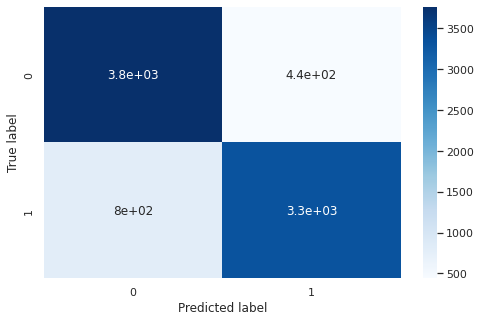

In [47]:
xgb_model_re = XGBClassifier(n_estimators=250,max_depth=32)
xgb_model_re.fit(X_train_rescale,y_train)
xgb_re_metrics = metrics_plot(xgb_model_re,X_train_rescale,y_train,X_test_rescale,y_test)

In [48]:
ML_COMPARISON_RESAM = pd.DataFrame([lr_re_metrics,dt_re_metrics,rf_re_metrics,v_re_metrics,gbdt_re_metrics,xgb_re_metrics],
                                   index=['LogisticRegression resampling','DecisionTree resampling','RandomForest resampling','VotingClassifier resampling','GradientBoosting resampling','XGBoost resampling'])
ML_COMPARISON_RESAM

,train_accuracy,accuracy,balanced_accuracy,F1_score,precision,recall,FNR
LogisticRegression resampling,0.603831,0.611338,0.611526,0.611338,0.611338,0.611338,0.388662
DecisionTree resampling,0.851069,0.682441,0.683473,0.682441,0.682441,0.682441,0.317559
RandomForest resampling,0.771919,0.720274,0.720123,0.720274,0.720274,0.720274,0.279726
VotingClassifier resampling,0.686194,0.679918,0.680425,0.679918,0.679918,0.679918,0.320082
GradientBoosting resampling,0.699225,0.693730,0.693466,0.693730,0.693730,0.693730,0.306270
XGBoost resampling,1.000000,0.850829,0.850344,0.850829,0.850829,0.850829,0.149171


In [49]:
FINAL_COMPARISON = pd.concat([ML_COMPARISON,ML_COMPARISON_RESAM])
FINAL_COMPARISON.sort_values(by='F1_score', ascending=False)

,train_accuracy,accuracy,balanced_accuracy,F1_score,precision,recall,FNR
RandomForest,0.788436,0.783402,0.500000,0.878548,0.783402,0.783402,0.216598
GradientBoosting,0.788907,0.783402,0.500000,0.878548,0.783402,0.783402,0.216598
XGBoost resampling,1.000000,0.850829,0.850344,0.850829,0.850829,0.850829,0.149171
VotingClassifier,0.788107,0.783591,0.501063,0.783591,0.783591,0.783591,0.216409
LogisticRegression,0.788201,0.783214,0.500194,0.783214,0.783214,0.783214,0.216786
DecisionTree,0.807631,0.774746,0.506419,0.774746,0.774746,0.774746,0.225254
XGBoost,0.940864,0.766654,0.506283,0.766654,0.766654,0.766654,0.233346
RandomForest resampling,0.771919,0.720274,0.720123,0.720274,0.720274,0.720274,0.279726
GradientBoosting resampling,0.699225,0.693730,0.693466,0.693730,0.693730,0.693730,0.306270
DecisionTree resampling,0.851069,0.682441,0.683473,0.682441,0.682441,0.682441,0.317559


By Analysing above Comparison,
* RandomForest without resampling have highest F1_score
* although RandomForest have highest F1_Score but __XGBoost with resampling__ have good metrics also

Finalizing model as XGBoost with resampling of data

# Final Model  
steps we need to perfom after resampling train data
* Fill Null values as median (numeric columns)
* use onehotencoding to convert catgorical features
* drop features with high correlation here greater than 0.7 (70%)
* fit model and predict test result

We will be using pipeline for performing this steps, first we will do __resampling__ 


In [50]:
train_0 = train[train['failure']==0]
train_1 = train[train['failure']==1]
train_0.shape,train_1.shape

((20921, 26), (5649, 26))

In [51]:
count0, count1 = train['failure'].value_counts()

Random over-sampling:
1    20921
0    20921
Name: failure, dtype: int64


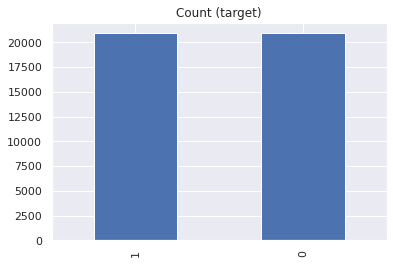

In [52]:
train_1_over = train_1.sample(count0, replace=True)
train_resample = pd.concat([train_1_over,train_0],axis=0)

print('Random over-sampling:')
print(train_resample.failure.value_counts())

train_resample.failure.value_counts().plot(kind='bar', title='Count (target)');

In [53]:
X_ = train_resample.drop('failure',axis=1)
y_ = train_resample[['failure']]

In [54]:
ohe = OneHotEncoder().fit(X_[['attribute_0']])
ohe.categories_

[array(['material_5', 'material_7'], dtype=object)]

In [55]:
transformer = ColumnTransformer([('imputer',SimpleImputer(strategy='median'),numerical_col),('oh',OneHotEncoder(categories=ohe.categories_),['attribute_0'])])

In [56]:
pipe = Pipeline(steps=[('transformer',transformer),
                       ('scaler',StandardScaler()),
                       ('model',XGBClassifier(n_estimators=250,max_depth=32))])

In [57]:
pipe.fit(X_,y_)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('imputer',
                                                  SimpleImputer(strategy='median'),
                                                  ['loading', 'attribute_2',
                                                   'attribute_3',
                                                   'measurement_0',
                                                   'measurement_1',
                                                   'measurement_2',
                                                   'measurement_3',
                                                   'measurement_4',
                                                   'measurement_5',
                                                   'measurement_6',
                                                   'measurement_7',
                                                   'measurement_8',
                                                   'measurement_9',


In [58]:
test_pred = pipe.predict(test)

In [59]:
submission = pd.DataFrame(columns=['id','failure'])
submission['id'] = test['id']
submission['failure'] = test_pred
submission.sample(10)

,id,failure
6019,32589,0
6289,32859,0
3919,30489,0
15869,42439,0
18377,44947,0
11934,38504,0
12988,39558,0
2735,29305,0
4652,31222,0
16514,43084,1


In [60]:
submission.to_csv('xgboost_approch1.csv', index=False)